In [5]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [6]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [12.0, 5.0],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Gaussian  models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on.. 


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

#  Inference about the speed of light

* At the end of the 19th century Simon Newcomb carried out several experiments to determine the speed of light.
* In each of them, Newcomb measured the time it took for light to travel 7,442 meters.
* The data seems to be normally distributed, but there some low values which are far from the mean (*outliers*).


In [13]:
#Below is the results of  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])


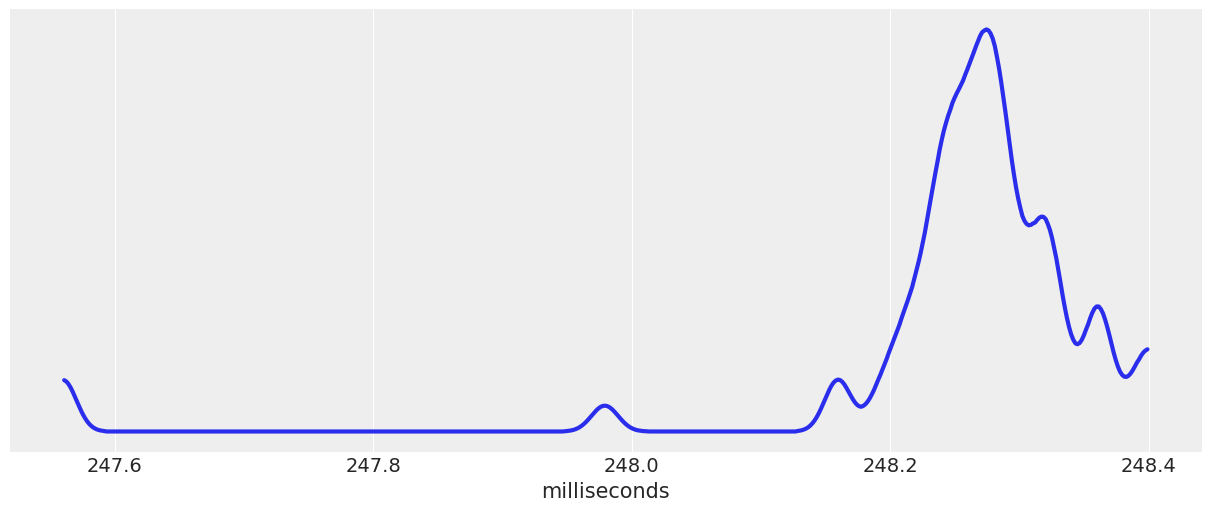

In [4]:
#the density plot is called kde (kernel density estimation)
az.plot_kde(data, figsize=[12,5])
plt.yticks([])
plt.xlabel('milliseconds');

# Back to the example of light speed, alternative (but not recommended) prior for $\mu$

If we have no idea about the possible location of $\mu$, we can use a uniform prior over a large interval: 
\begin{align}
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y & \sim \mathcal{N}(\mu, \sigma)
\end{align}


* For instance:
    * $l=data.min() / 5$
    * $h=l+data.min() * 5$. 
    
    
* In this way the prior is  much broader then the data.

* However, whenever possible  do **not** use the data to define the prior.
* Also, avoid prior with sharp limits, which can  make the sampling problematic.
* Prior with sharp limits are appropriate only if the variable is truly defined over an interval: for instance the bias $\theta$ of the coin is bounded in (0,1) and thus the Beta is an appropriate distribution.

# Implementation

In [14]:
with pm.Model() as model_newcomb:
    #prior for the location of mu
    # Based on our experience, we  believe  mu to lie with very high probability (99%) in (0, 480).
    # This corresponds to a normal distribution with mu = 240 (mid-point of the interval), sigma = 80 
    # obtained as ( (480- 0) / 6)
    # Of course the choice of the prior is subjective. In case of doubt, the important is to have a prior covering a   broad range.
    mu = pm.Normal('mu', 240, 80)
    
    #According to our experience, a plausible value for the standard deviation of the noise is 2.
    # the median sigma according to the distribution below  is about 2.
    sigma = pm.HalfNormal('sigma', sd=3)

    
    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb = pm.sample()

/var/folders/tr/48q31n41473glpbhlkdzc1qh0000gp/T/ipykernel_60000/907513639.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_newcomb = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for bot

/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 84 seconds.


# Inspecting the trace 


/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


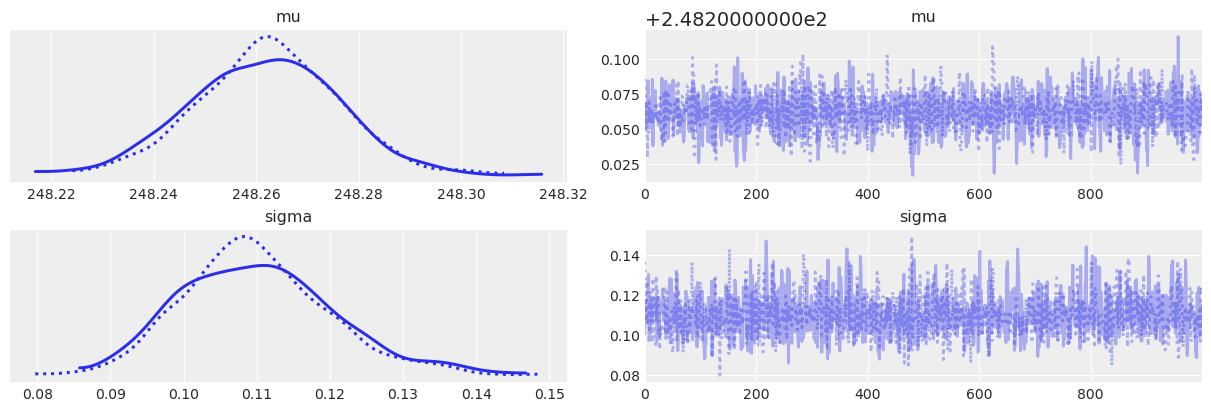

In [15]:
# The traceplot shows both parameters.
# The  density plots are smooth and the chains are well-mixing.
az.plot_trace(trace_newcomb);

In [16]:
az.summary(trace_newcomb) 

/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.014,248.234,248.285,0.0,0.0,1516.0,1039.0,1.00
sigma,0.110,0.010,0.091,0.128,0.0,0.0,1605.0,1396.0,1.01


# What if we change the prior?

In [18]:
with pm.Model() as model_newcomb_2:

    #mu = pm.Normal('mu', 240, 80)
    #we have different beliefs about mu; larger mean and larger uncertainty.
    mu = pm.Normal('mu', 300, 100)
    
    #identical to the previous model
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb_2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano 

/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/scalar/basic.py:1955: RuntimeWarning: invalid value encountered in true_divide
  return x / y
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/p

In [19]:
# The posterior is practically identical under the two different priors.
# This is  good: the data are strong enough to converge to the same posterior.
# The likelihood overwhelms the prior; the results are thus robust to the specification of the prior.


a = az.summary(trace_newcomb) 
b = az.summary(trace_newcomb_2) 
pd.concat([a,b])

/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.014,248.234,248.285,0.0,0.0,1516.0,1039.0,1.00
sigma,0.110,0.010,0.091,0.128,0.0,0.0,1605.0,1396.0,1.01
mu,248.262,0.014,248.235,248.287,0.0,0.0,1611.0,1316.0,1.00
sigma,0.109,0.010,0.091,0.128,0.0,0.0,1549.0,1294.0,1.00


# Posterior prediction (forse da spostare nella regressione o nel modello gerarchico)

* Suppose you carry out a new measurement.  Make a prediction about its value based on the posterior.
* The simples answer is to use the posterior mean, 248.262 according to the summary in the previous slide.

* Yet  this singular prediction ignores two  sources of variability:

    * the effect of the noise
    * posterior variability of $\mu$ and  $\sigma$. 

* We should consider the entire of plausible values contained in the posterior sampels, to quantify the uncertainty of our prediction.

# Posterior prediction

* The trace contains some thousands (e.g., 4000) parameter samples  $<\mu_i, \sigma_i >$. 


* This is a numerical approximation of the posterior density of $\mu$ and $\sigma$.


* The probabilistic prediction for the next observation is computed  by simulating a measurement prediction for each parameter set:

$$
Y_{\text{new}}^{(i)} | \mu_i, \sigma_i  \; \sim \; N\left(\mu_i, \sigma_i\right)\;\; i=1,2...4000$$



# Posterior prediction

* Each parameter set  $<\mu_i, \sigma_i >$  yields a different prediction:

$$
\left[
\begin{array}{ll} 
\mu^{(1)} &   \sigma^{(1)} \\
\mu^{(2)} & \sigma^{(2)} \\
\vdots & \vdots & \vdots \\
\mu^{(4000)}  & \sigma^{(4000)} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
Y_{\text{new}}^{(1)} \\
Y_{\text{new}}^{(2)} \\
\vdots \\
Y_{\text{new}}^{(4000)} \\
\end{array}
\right]
$$

The resulting collection of 4,000 predictions $Y_{\text{new}}$ approximates the posterior prediction for a new measurement, accounting for two sources of uncertainty:

   * uncertainty in the estimation of $\mu, \sigma$
   * uncertainty in the realization of the noise.

In [13]:
# we compute the posterior prediction by adding a single line to our pymc3 code.
# it could be possible to obtain the same result by extracting samples from the trace, but I was unable to do that.
with pm.Model() as model_newcomb:
    #model as before (first variant)
    mu = pm.Normal('mu', 240, 80)
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    #prediction
    prediction = pm.Normal('prediction', mu=mu, sd=sigma)
        
    trace_newcomb_pred = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prediction, sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [14]:
az.summary(trace_newcomb_pred, var_names='prediction')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prediction,248.262,0.111,248.055,248.469,0.002,0.001,4701.0,2607.0,1.0


# Checking the model: posterior predictive checks


* Even if the sampling  has converged correctly, the model might be inadequate.

* Posterior predictive check (PPC) is a way to check that the model adequately fits the data.

* Idea: 
    * makes prediction using the posterior of the parameters;  
    * verify that the distribution of the simulated data  resembles the distribution of the actual data.

Denoting the simulated  data as $\tilde{y}$ and the model parameters as $\theta$:

\begin{align}
\underbrace{p(\tilde{y} \,|\, y)}_{\text{distribution of data simulated from the fitted model, trained on data y}} & 
= \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta \\
\end{align}


where:

* $y$ is the observed data 
* $\theta$ corresponds to the model parameters: $\theta = [\mu, \sigma]$ in our example.

# Checking the model: posterior predictive checks

\begin{align}
p(\tilde{y} \,|\, y)  \\
& = \int 
\underbrace{p(\tilde{y} \,|\, \theta)}_{\text{samples given a value of } \theta}
\, \underbrace{p(\theta \,|\, y)}_{\text{posterior of } \theta} \, d\theta \\
\end{align}




# Posterior predictive checks

* We  need  less samples for computing PPC relative to the MCMC sample.
 
We compute  $\tilde{y}$ as follows:

1. We randomly choose an index of the `trace` generated by PyMC3, i.e.,  a sample $< \mu_i, \sigma_i>$.
2. We generate a _synthetic data_ using the same likelihood of the model: $\tilde{y_i} \sim N(\mu_i, \sigma_i)$
3. We repeat 1 and 2 until we obtain the required number of samples.

* PPCs allow validating a model  and revising if necessary.


In [27]:
with model_newcomb:
    # select 500 samples <mu_s ,sigma_s> from the trace
    # for each samples, compute a draw N(mu_s ,sigma_s) 
    # The ppc variable is a dictionary, with the keys being the name of the observed variable in our model and the values an array of shape (samples, size). 
    # The dictionary allows dealing with models with more than one observed variable. 
    ppc = pm.sample_posterior_predictive(trace_newcomb, samples=500)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


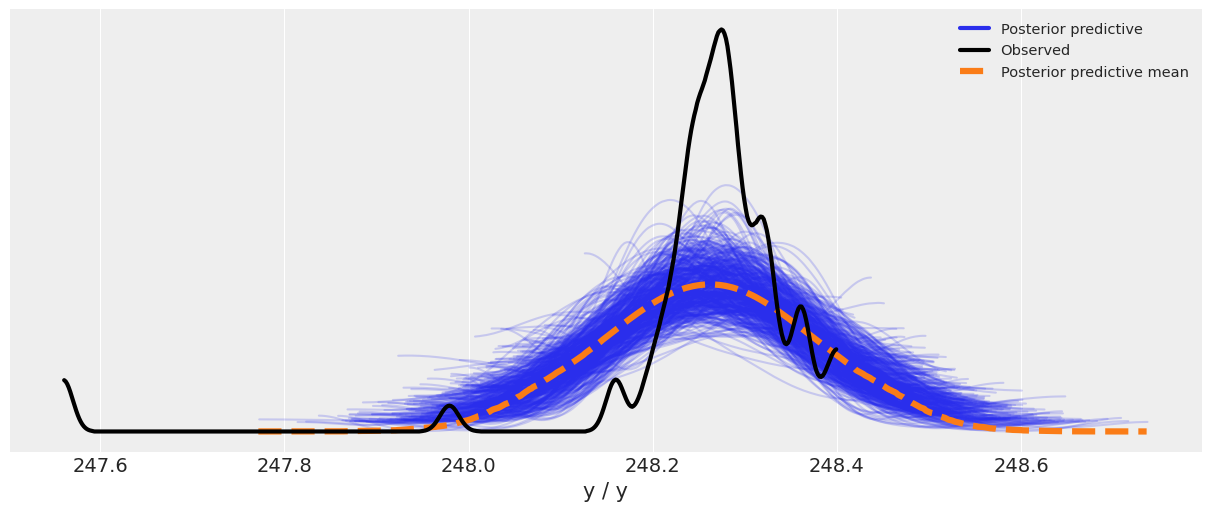

In [23]:
# the density reproduced by the model is too low around the center and does cover the long left tail adequately.
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_newcomb));

#  Robust models

* The previous model  assumes a normal distribution, yet there are outliers the which are too far from the mean values for the normal model. 

* These points could be due to experimental errors. If we are sure that this is the case,  we could remove them from our dataset (leaving a record of the removal and the reasons why we did it). 

* A more principled approach option is to adopt a likelihood which is *robust* to outliers.

#  The normal distribution has light tails

* The normal distribution is  sensitive to outliers. 


* The probability of finding a value falls rapidly as we move away from the mean; it is practically negligible when we are more than 3 standard deviation from the mean.


* If the data contains observations which are even further from the mean, the normal distribution is not a good model. 


* Probability of lying *outside* the interval $[ \mu - k \sigma, \mu + k \sigma]$:

| k |   \begin{equation} P \end{equation}|
|:-:|-:-|
| 1 |  0.3173 |
| 2 | 0.0455  |
| 3 | 0.0026 |
| 4 | 0.00006 |

# Student's t distribution


<img src='img/Student_t.png' width=400 align="center" > 

* It is defined by a mean, a scale $\sigma$ (related to the spread of the distribution) and by $\nu$ (referred to as *degrees of freedom* in the literature of hypothesis testing).

*  $\nu$ controls how _heavy_ the tails of the distribution are. 

    *  $\nu > 30$: the Student is practically equivalent to a Gaussian. 

    * $\nu = 4$ is a common choice to have a robust model with heavy tails, which can model observations that are far away from the mean.

# Comparing the normal and the t distribution ($\nu$=4)


* Probability of lying *outside* the region $\mu \pm k \sigma$:
    * $P = P( x < \mu - k \sigma) +  P(x > \mu + k \sigma) $ 

| k |   Normal | t ($\nu$=4)
|:-:|-:-|-:-|    
    | 1 |  0.32 | 0.38    |
    | 2 | 0.04 |  0.12 | 
    | 3 | 0.002 | 0.04 |
    | 4 | 0.00006 | 0.02 |
    
* The 99% interval is defined as:

    * $\mu \pm 2.58 \sigma$ for the normal distribution;
   
    * $\mu \pm 4.61 \sigma$ for the t distribution ($\nu$=4)

# Robust probabilistic model

\begin{align}
y & \sim StudentT (\mu, \sigma \nu=4) && \text{the observation are  allowed to contain outliers}\\
\mu &\sim N(\mu_{\mu}, \sigma_{\mu}) && \text{prior beliefs about } \mu\\ 
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) && \text{prior beliefs about } \sigma \\
\end{align}

* More sophisticated approaches would treat $\nu$ as a further parameter by assining a prior to it. 

In [39]:
with pm.Model() as model_t:
    #the priors are the same as those of  the first variant
    mu_t      = pm.Normal('mu', 240, 80)
    sigma_t = pm.HalfNormal('sigma', sd=3)

    #robust likelihood
    y              = pm.StudentT('y', mu=mu_t, sd=sigma_t, nu=4, observed=data)

    #prediction for a new measurement
    #prediction = pm.StudentT('prediction', mu=mu_t, sd=sigma_t, nu=4)
        
    trace_t = pm.sample() 

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [42]:
# Let us compare the estimates of the two models
with model_t:
    summary_t = az.summary(trace_t)
with model_newcomb:
    summary= az.summary(trace_newcomb)
pd.concat([summary_t, summary])[ ["mean","sd" ]]

,mean,sd
mu,248.275,0.007
sigma,0.047,0.006
mu,248.262,0.014
sigma,0.109,0.010


# Estimates comparison

* The estimation of $\mu$ is identical for the normal and the t model.

* But the t model  estimates a much lower  $\sigma$  (about half) compared to the normal model. This is a consequence of the t- distribution giving less weight (being less surprised) by values away from the mean. 

* This allows keeping higher the density around the bulk of the data, as shown by the posterior predictive check.

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:xlabel='y / y'>

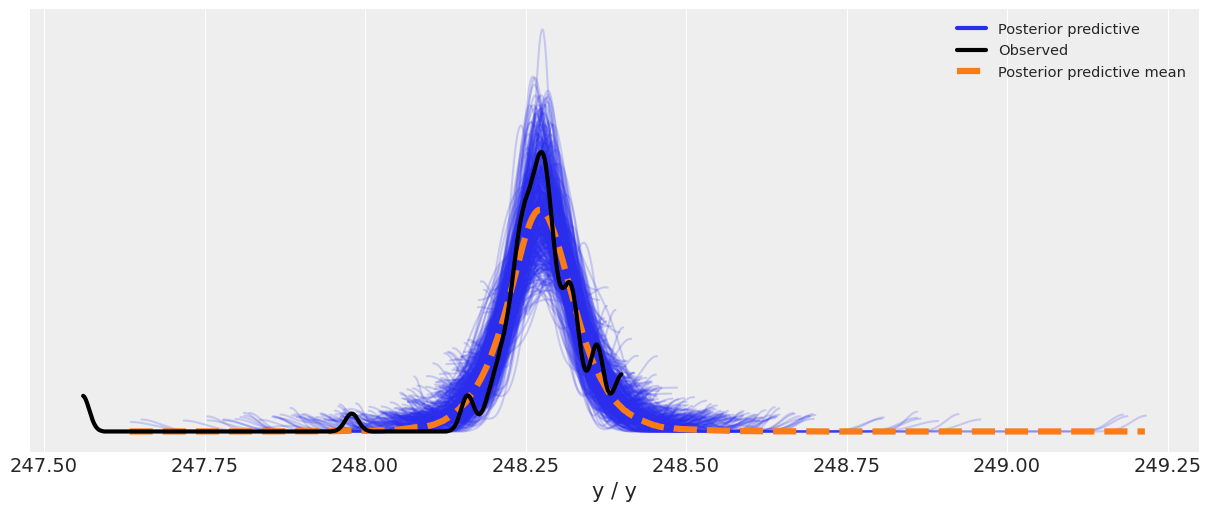

In [46]:
with model_t:
    ppc_t = pm.sample_posterior_predictive(trace_t, samples=500)
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_t, model=model_t))

# Exercises


*  For the `model_g`. Use a Gaussian for the mean, centered at the empirical mean. Try modifying the standard deviation of that prior. How robust/sensitive are the results to the choice of prior?


* The Gaussian is a distribution _without limits_ that is, it is valid in the interval $[-\infty, \infty]$, in the previous example we use it to model data that we know have limits. What do you think of this choice?


* Using the speed of light data, calculate the mean and standard deviation with and without the _outilers_, compare those values ​​with those obtained with the `model_g` and with the `model_t`.
